In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
plt.rcParams['figure.figsize'] = [10, 8]
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# -----------------------------------------------
# Load and Preprocess Johnson & Johnson Dataset
# -----------------------------------------------
df_jj = pd.read_csv('/content/drive/MyDrive/jj.csv')
df_jj.columns = ['Date', 'Value']
df_jj['Date'] = pd.to_datetime(df_jj['Date'])
df_jj.set_index('Date', inplace=True)


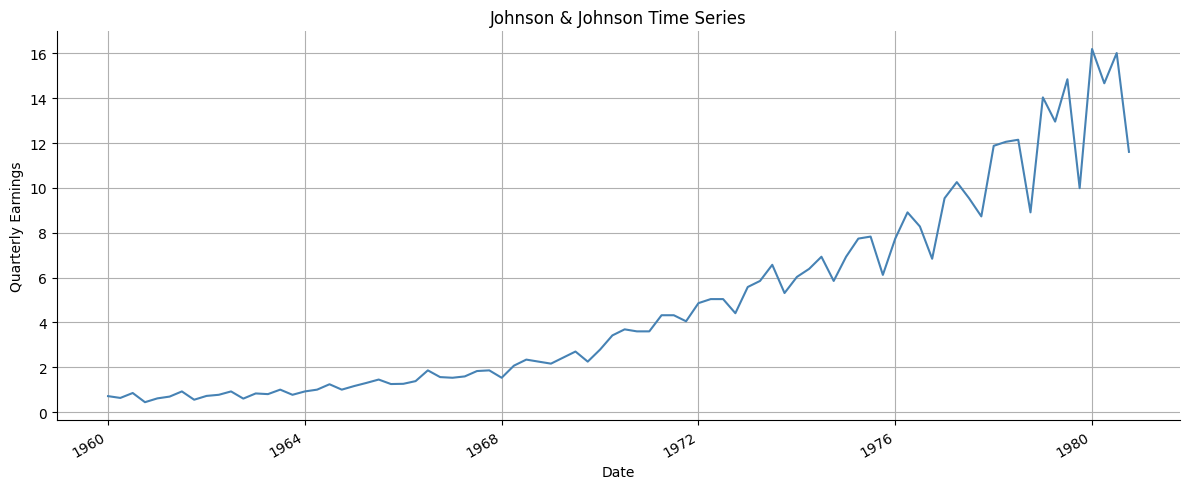

In [4]:
# ---------------------------------------------------
# Plot Johnson & Johnson Time Series Data (Line Plot)
# ---------------------------------------------------
df_jj['Value'].plot(kind='line', title='Johnson & Johnson Time Series', color='steelblue', figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Quarterly Earnings")
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


In [5]:
df_jj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


**Test For Non-Stationary**

In [6]:
# -----------------------------------------------------
# Augmented Dickey-Fuller Test for Stationarity Checks
# -----------------------------------------------------

# ADF on Original Series (Level)
adf_level_result = adfuller(df_jj['Value'].dropna())
print("ADF Test p-value (Original Series):", adf_level_result[1])

# ADF on First-Differenced Series
adf_first_diff_result = adfuller(df_jj['Value'].diff().dropna())
print("ADF Test p-value (1st Difference):", adf_first_diff_result[1])

# ADF on Second-Differenced Series
adf_second_diff_result = adfuller(df_jj['Value'].diff().diff().dropna())
print("ADF Test p-value (2nd Difference):", adf_second_diff_result[1])

ADF Test p-value (Original Series): 1.0
ADF Test p-value (1st Difference): 0.9088542416911305
ADF Test p-value (2nd Difference): 0.006051099869603682


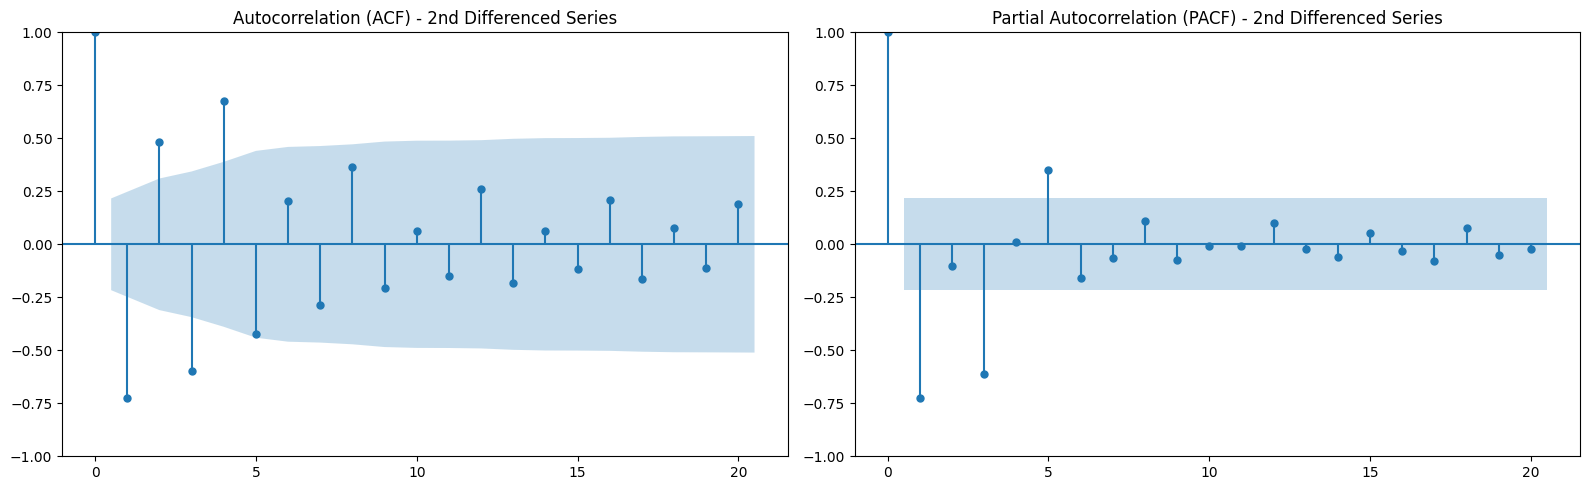

In [7]:
# -------------------------------------------------------
# Apply Second-Order Differencing to JJ Time Series Data
# -------------------------------------------------------
jj_diff2 = df_jj['Value'].diff().dropna().diff().dropna()
# -------------------------------------------------------
# Plot ACF and PACF to Guide ARIMA Model Selection
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(jj_diff2, lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF) - 2nd Differenced Series")
plot_pacf(jj_diff2, lags=20, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF) - 2nd Differenced Series")
plt.tight_layout()
plt.show()

In [8]:
# ------------------------------------------------------------------
# Perform Grid Search to Identify Optimal ARIMA(p,2,q) Configuration
# ------------------------------------------------------------------
min_aic = float("inf")
optimal_order = None
optimal_arima_model = None

for p in range(4):
    for q in range(4):
        try:
            temp_model = ARIMA(df_jj['Value'], order=(p, 2, q)).fit()
            if temp_model.aic < min_aic:
                min_aic = temp_model.aic
                optimal_order = (p, 2, q)
                optimal_arima_model = temp_model
        except:
            continue

print("Optimal ARIMA Model Order (p, d=2, q):", optimal_order)

Optimal ARIMA Model Order (p, d=2, q): (3, 2, 3)


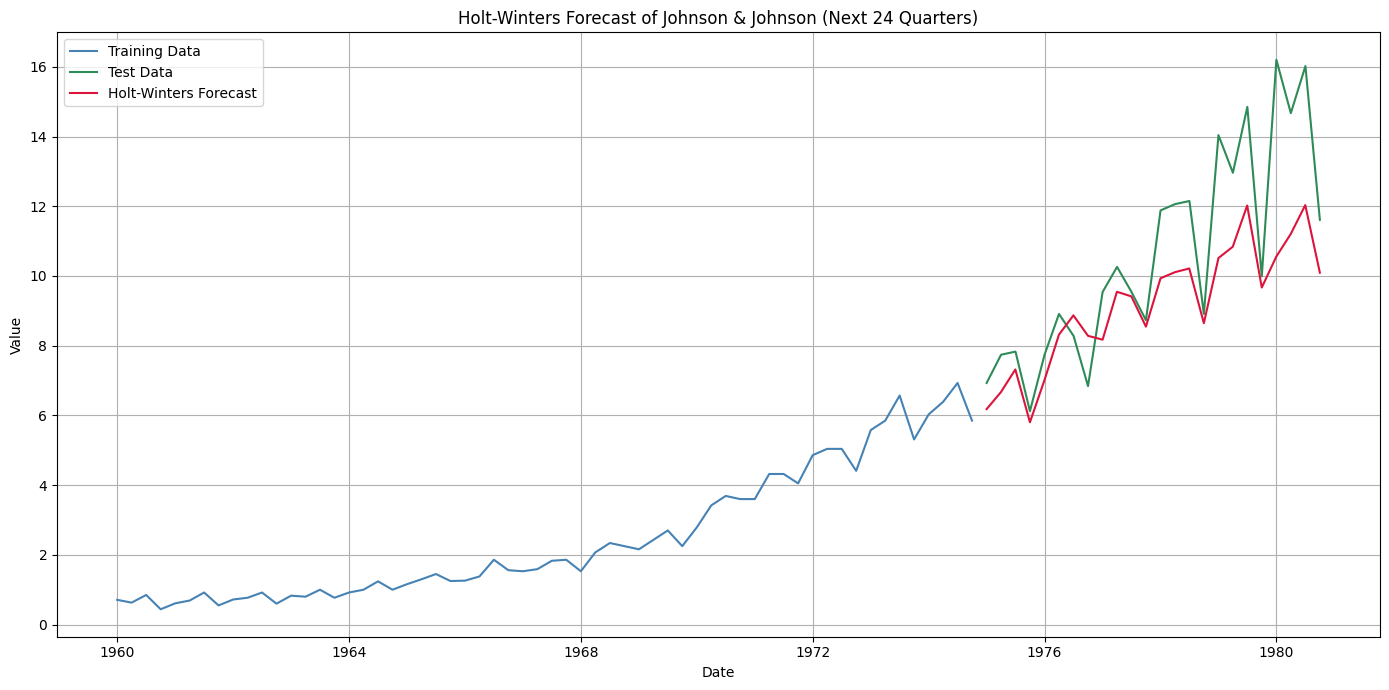

MAE  : 1.5787
MSE  : 4.4277
RMSE : 2.1042


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# -----------------------------------------------------------
# 1. Duplicate Original JJ Dataset for Smoothing and Modeling
# -----------------------------------------------------------
df_jj_smooth = df_jj.copy()

# -----------------------------------------------------------
# 2. Apply Moving Average and EWMA Smoothing (Optional Step)
# -----------------------------------------------------------
df_jj_smooth['SMA_6'] = df_jj_smooth['Value'].rolling(window=6).mean()
df_jj_smooth['SMA_12'] = df_jj_smooth['Value'].rolling(window=12).mean()
df_jj_smooth['EWMA_12'] = df_jj_smooth['Value'].ewm(span=12, adjust=False).mean()

# -----------------------------------------------------------
# 3. Split Dataset into Training and Testing (Last 24 Quarters)
# -----------------------------------------------------------
n_test_periods = 24
train_jj = df_jj_smooth[:-n_test_periods]
test_jj = df_jj_smooth[-n_test_periods:]

# -----------------------------------------------------------
# 4. Fit Holt-Winters Model with Additive Trend and Multiplicative Seasonality
# -----------------------------------------------------------
hw_model = ExponentialSmoothing(
    train_jj['Value'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24  # 24 quarters = 6 years if quarterly data
)
hw_fit = hw_model.fit()

# -----------------------------------------------------------
# 5. Forecast the Next 24 Quarters
# -----------------------------------------------------------
forecast_steps = 24
forecast_index = pd.date_range(
    start=train_jj.index[-1] + pd.DateOffset(months=3),
    periods=forecast_steps,
    freq='QS'
)
hw_forecast = hw_fit.forecast(forecast_steps)
hw_forecast_series = pd.Series(hw_forecast.values, index=forecast_index, name='Forecast')

# -----------------------------------------------------------
# 6. Plot Actual Data and Holt-Winters Forecast
# -----------------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(train_jj.index, train_jj['Value'], label='Training Data', color='steelblue')
plt.plot(test_jj.index, test_jj['Value'], label='Test Data', color='seagreen')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Holt-Winters Forecast', color='crimson')
plt.title("Holt-Winters Forecast of Johnson & Johnson (Next 24 Quarters)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 7. Evaluate Forecast Accuracy on Test Period
# -----------------------------------------------------------
forecast_eval = hw_forecast_series[:len(test_jj)]
mae_score = mean_absolute_error(test_jj['Value'], forecast_eval)
mse_score = mean_squared_error(test_jj['Value'], forecast_eval)
rmse_score = np.sqrt(mse_score)

print(f"MAE  : {mae_score:.4f}")
print(f"MSE  : {mse_score:.4f}")
print(f"RMSE : {rmse_score:.4f}")


**Build an RNN based model (LSTM, GRU)**

Epoch 1/50
8/8 - 6s - 745ms/step - loss: 0.1255 - val_loss: 0.5017
Epoch 2/50
8/8 - 0s - 19ms/step - loss: 0.0903 - val_loss: 0.3515
Epoch 3/50
8/8 - 0s - 20ms/step - loss: 0.0693 - val_loss: 0.2068
Epoch 4/50
8/8 - 0s - 18ms/step - loss: 0.0663 - val_loss: 0.1194
Epoch 5/50
8/8 - 0s - 23ms/step - loss: 0.0534 - val_loss: 0.1028
Epoch 6/50
8/8 - 0s - 33ms/step - loss: 0.0381 - val_loss: 0.1035
Epoch 7/50
8/8 - 0s - 18ms/step - loss: 0.0280 - val_loss: 0.1014
Epoch 8/50
8/8 - 0s - 18ms/step - loss: 0.0386 - val_loss: 0.1182
Epoch 9/50
8/8 - 0s - 20ms/step - loss: 0.0389 - val_loss: 0.1212
Epoch 10/50
8/8 - 0s - 17ms/step - loss: 0.0262 - val_loss: 0.0968
Epoch 11/50
8/8 - 0s - 18ms/step - loss: 0.0234 - val_loss: 0.0981
Epoch 12/50
8/8 - 0s - 17ms/step - loss: 0.0246 - val_loss: 0.0978
Epoch 13/50
8/8 - 0s - 18ms/step - loss: 0.0294 - val_loss: 0.0958
Epoch 14/50
8/8 - 0s - 18ms/step - loss: 0.0380 - val_loss: 0.1277
Epoch 15/50
8/8 - 0s - 18ms/step - loss: 0.0315 - val_loss: 0.0923
Epo

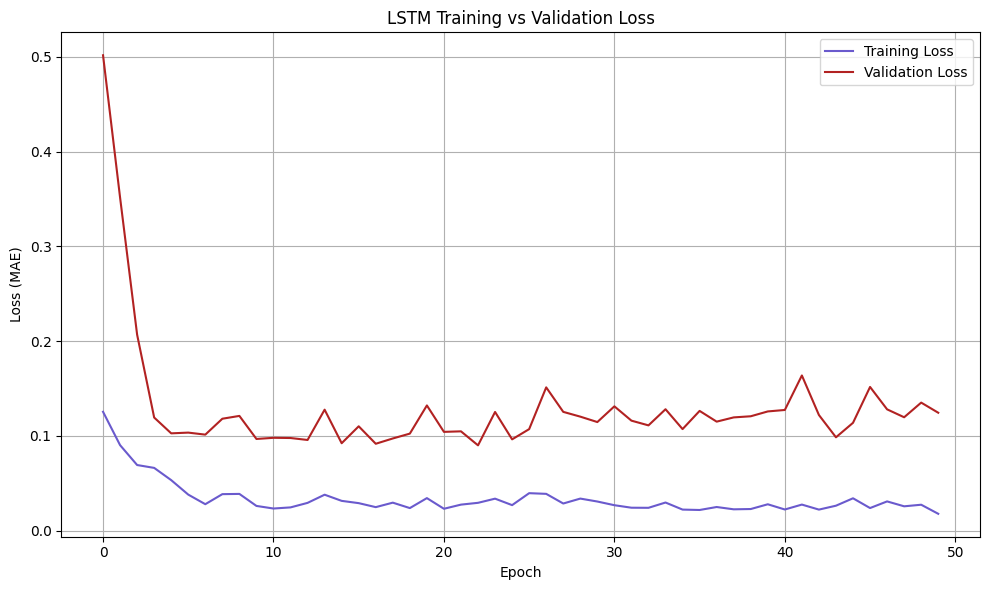

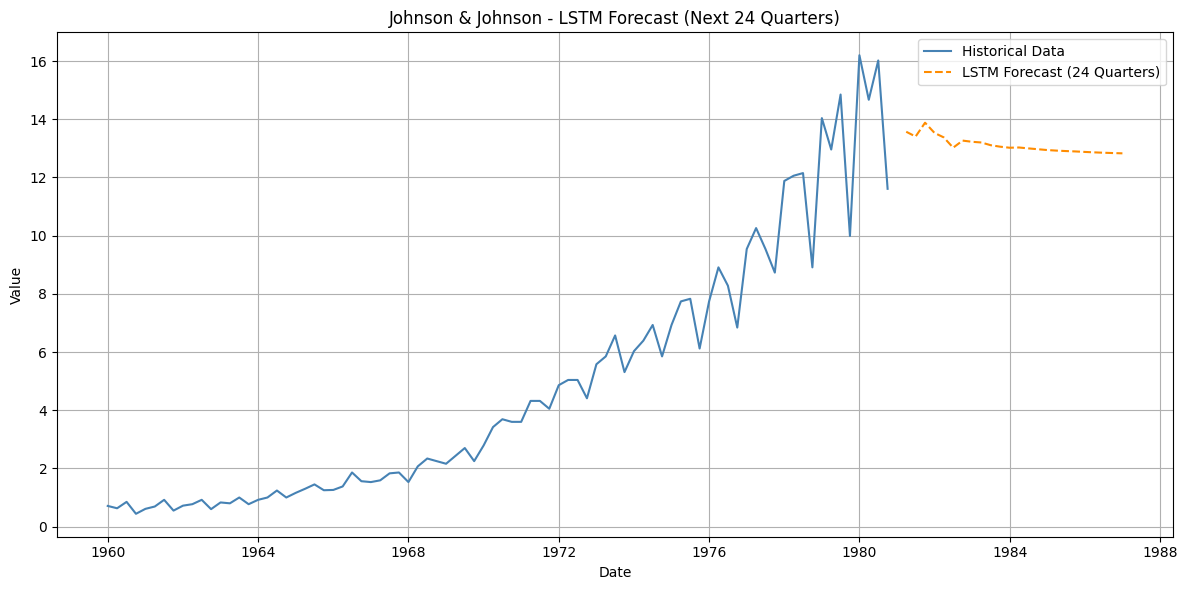

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
LSTM Model Evaluation Metrics:
MAE  : 1.9620
MSE  : 4.5932
RMSE : 2.1432
R²   : 0.2150


In [10]:
from pandas import DataFrame, concat
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------------------------
# Load and Normalize Johnson & Johnson Data
# -------------------------------------------------
df_jj = pd.read_csv('/content/drive/MyDrive/jj.csv')
df_jj.columns = ['Date', 'Value']
df_jj['Date'] = pd.to_datetime(df_jj['Date'])
df_jj.set_index('Date', inplace=True)

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_jj[['Value']].astype('float32'))

# -------------------------------------------------
# Convert Time Series to Supervised Learning Format
# -------------------------------------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

supervised_data = series_to_supervised(normalized_values, n_in=6, n_out=1)

# -------------------------------------------------
# Prepare Train-Test Data
# -------------------------------------------------
X_all = supervised_data.iloc[:, :-1]
y_all = supervised_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------------------------
# Build and Train LSTM Network
# -------------------------------------------------
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mae')

training_history = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -------------------------------------------------
# Plot Training and Validation Loss
# -------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['loss'], label='Training Loss', color='slateblue')
plt.plot(training_history.history['val_loss'], label='Validation Loss', color='firebrick')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Forecast Next 24 Quarters
# -------------------------------------------------
last_seq = normalized_values[-6:]
future_predictions = []

for _ in range(24):
    input_seq = last_seq.reshape(1, 6, 1)
    next_val = model_lstm.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(next_val)
    last_seq = np.append(last_seq[1:], [[next_val]], axis=0)

# Inverse scale
forecast_values = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future time index
last_date = df_jj.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=24, freq='Q')
df_forecast = pd.DataFrame(forecast_values, index=forecast_index, columns=['Forecast'])

# -------------------------------------------------
# Plot Forecast Results
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_jj.index, df_jj['Value'], label='Historical Data', color='steelblue')
plt.plot(df_forecast.index, df_forecast['Forecast'], label='LSTM Forecast (24 Quarters)', color='darkorange', linestyle='--')
plt.title('Johnson & Johnson - LSTM Forecast (Next 24 Quarters)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Evaluate LSTM Performance on Test Data
# -------------------------------------------------
y_test_pred_scaled = model_lstm.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_test_pred_actual = scaler.inverse_transform(y_test_pred_scaled)

mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
mse = mean_squared_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_test_pred_actual)

print("LSTM Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0543 - val_loss: 0.2386
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - val_loss: 0.0500
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0234
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034 - val_loss: 0.0254
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018 - val_loss: 0.0171
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.5269e-04 - val_loss: 0.0190
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.2316e-04 - val_loss: 0.0200
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.8182e-04 - val_loss: 0.0173
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.4822e-04 - val_loss: 0.0171
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.2621e-04 - val_loss: 0.0171
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.6270e-04 - val_loss: 0.0170
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.3

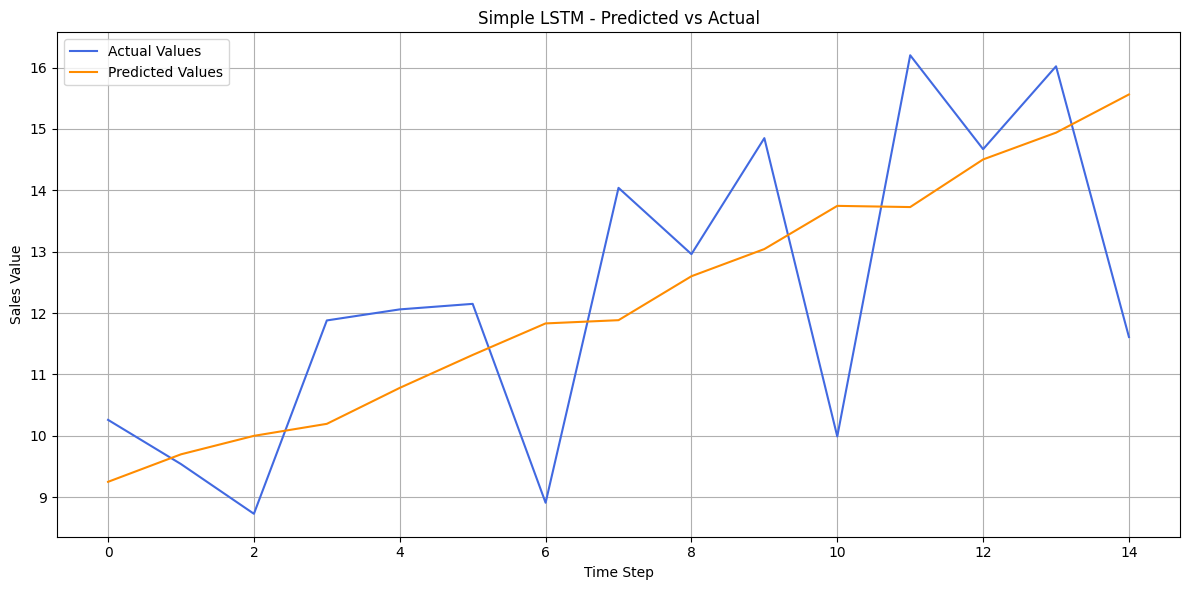

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------------------------
# Normalize the Johnson & Johnson Dataset
# -------------------------------------------------
scaler = MinMaxScaler()
df_jj[['Value']] = scaler.fit_transform(df_jj[['Value']])

# -------------------------------------------------
# Create LSTM-Compatible Sequences
# -------------------------------------------------
def generate_lstm_sequences(series, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(series) - sequence_length):
        X_seq.append(series[i:i + sequence_length])
        y_seq.append(series[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

seq_len = 12
X_all, y_all = generate_lstm_sequences(df_jj['Value'].values, seq_len)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

# -------------------------------------------------
# Split into Training and Testing Sets
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# -------------------------------------------------
# Define and Train the LSTM Model
# -------------------------------------------------
model_lstm_simple = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model_lstm_simple.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------------------------
# Function to Plot Actual vs Predicted Results
# -------------------------------------------------
def plot_lstm_forecast(model, X_val, y_val, label="Model"):
    y_pred = model.predict(X_val)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_val.reshape(-1, 1)), label='Actual Values', color='royalblue')
    plt.plot(scaler.inverse_transform(y_pred), label='Predicted Values', color='darkorange')
    plt.title(f"{label} - Predicted vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Sales Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Visualize the Model's Forecast
# -------------------------------------------------
plot_lstm_forecast(model_lstm_simple, X_test, y_test, "Simple LSTM")


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# -------------------------------------------------
# Generate Predictions from the LSTM Model
# -------------------------------------------------
y_pred_scaled = model_lstm_simple.predict(X_test)

# Inverse-transform predictions and true values to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred_scaled).flatten()

# -------------------------------------------------
# Compute Evaluation Metrics
# -------------------------------------------------
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

# -------------------------------------------------
# Display LSTM Model Performance
# -------------------------------------------------
print("Simple LSTM Model Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Simple LSTM Model Evaluation:
MAE  : 1.6604
RMSE : 2.0238
MAPE : 0.1437


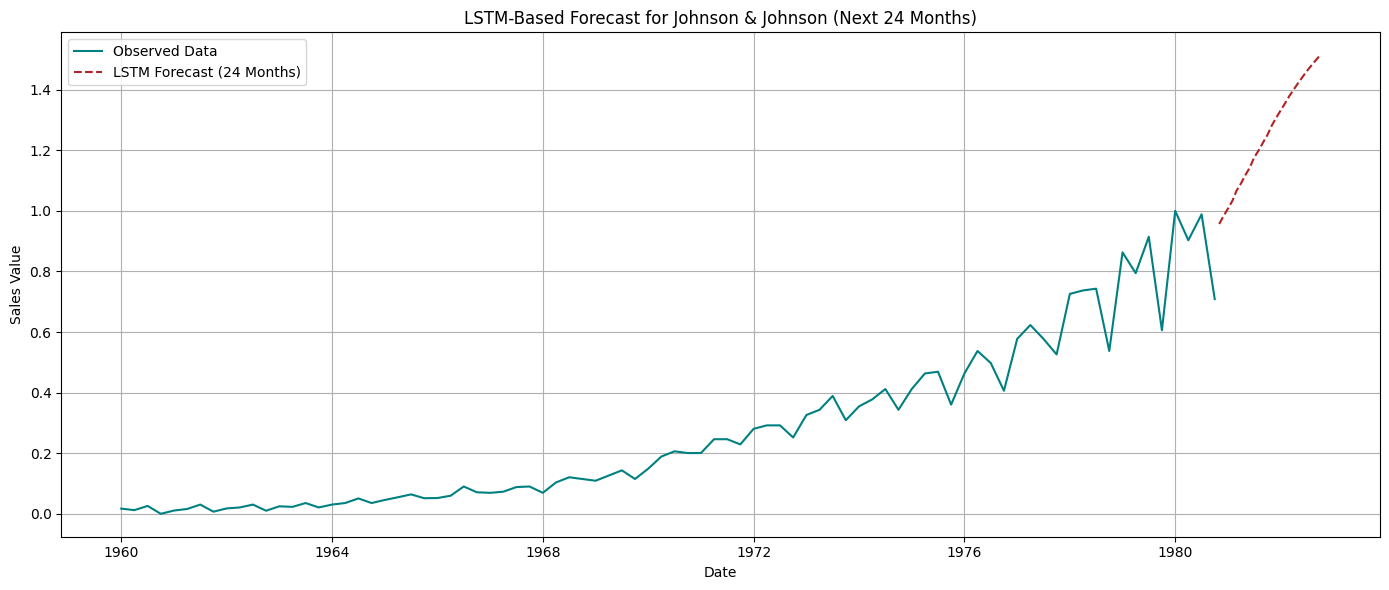

In [18]:
# -----------------------------------------------------------
# Define Forecasting Function for Future Time Steps
# -----------------------------------------------------------
def generate_future_forecast(model, scaled_series, scaler, forecast_steps=24, input_length=12):
    recent_sequence = scaled_series[-input_length:].reshape(1, input_length, 1)
    future_preds = []

    for _ in range(forecast_steps):
        next_value = model.predict(recent_sequence, verbose=0)[0][0]
        future_preds.append(next_value)
        recent_sequence = np.append(recent_sequence[:, 1:, :], [[[next_value]]], axis=1)

    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# -----------------------------------------------------------
# Refit Scaler and Scale Full Series for Forecasting
# -----------------------------------------------------------
scaler = MinMaxScaler()
normalized_series = scaler.fit_transform(df_jj['Value'].values.reshape(-1, 1))

# -----------------------------------------------------------
# Generate Forecast for the Next 24 Months (Monthly Step)
# -----------------------------------------------------------
forecast_values = generate_future_forecast(
    model= model_lstm_simple,
    scaled_series=normalized_series,
    scaler=scaler,
    forecast_steps=24,
    input_length=12
)

# -----------------------------------------------------------
# Create Future Monthly Date Range for Plotting
# -----------------------------------------------------------
start_date = df_jj.index[-1] + pd.DateOffset(months=1)
forecast_dates = pd.date_range(start=start_date, periods=24, freq='MS')

# -----------------------------------------------------------
# Plot Original Series and Forecasted Values
# -----------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(df_jj.index, scaler.inverse_transform(normalized_series), label='Observed Data', color='teal')
plt.plot(forecast_dates, forecast_values, label='LSTM Forecast (24 Months)', color='firebrick', linestyle='--')
plt.title('LSTM-Based Forecast for Johnson & Johnson (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
